In [1]:
from mintalib.samples import sample_prices


%load_ext cython

In [2]:
prices = sample_prices()



In [ ]:
# Placeholders for cython functions

def calc_curve(series, period=20):
    pass

def calc_qsf(series, period=20):
    pass



In [42]:
%%cython -c=-Wno-unreachable-code

import sys
import numpy as np

from libc.math cimport isnan
from libc cimport math

cdef double NAN = float('nan')

from mintalib.core import wrap_result



cdef enum:
    QUADREG_SLOPE = 0
    QUADREG_CURVE = 1
    QUADREG_RVALUE = 2
    QUADREG_RSQUARE = 3
    QUADREG_RMSERROR = 4
    QUADREG_FORECAST = 5
    QUADREG_BADOPTION = 6



def quadratic_regression(series, long period=20, *, int option=0, int offset=0, bint wrap=False):
    """ Curve (quadratic regression) """

    if option < 0 or option >= QUADREG_BADOPTION:
        raise ValueError("Invalid option %d" % option)

    cdef const double[:] zs = np.asarray(series, float)
    cdef long size = zs.size

    cdef object result = np.full(size, np.nan)
    cdef double[:] output = result

    cdef double x, sx, sxx, vxx
    cdef double y, sy, syy, vyy
    cdef double z, sz, szz, vzz
    cdef double s, sxz, vxz, syz, vyz

    cdef double slope, curve, intercept, mse, rmse, rvalue
    cdef double xbeg = (1-period) / 2, xend = xbeg + (period -1)

    cdef bint skip = 0

    cdef long i = 0, j = 0

    if period >= size:
        return result

    x = xbeg
    s = sx = sxx = sy = syy = 0.0
    for i in range(period):
        y = x * x
        s += 1
        sx += x
        sy += y
        sxx += x*x
        syy += y*y
        x += 1.0

    vxx = (sxx / s - sx * sx / s / s )
    vyy = (syy / s - sy * sy / s / s )

    if vxx <= 0 or vyy <= 0:
        return result

    for j in range(period - 1, size):
        skip = False

        x = xbeg
        sz = sxz = szz = 0.0
        i = j - period + 1

        while i <= j:
            z = zs[i]
            if z != z:
                skip = True
                break
            sz += z
            sxz += x * z
            szz += z * z
            x += 1.0
            i += 1

        if skip:
            continue

        vxz = (sxz / s - sx * sz / s / s)
        vzz = (szz / s - sz * sz / s / s)

        slope = vxz / vxx

        if option == QUADREG_SLOPE:
            output[j] = slope
            continue

        x = xbeg
        sz = syz = szz = 0.0
        i = j - period + 1

        while i <= j:
            y = x * x
            z = zs[i] - slope * x
            if z != z:
                skip = True
                break
            sz += z
            syz += y * z
            szz += z * z
            x += 1.0
            i += 1

        if skip:
            continue

        vyz = (syz / s - sy * sz / s / s)
        vzz = (szz / s - sz * sz / s / s)

        curve = vyz / vyy
        intercept = (sz - curve * sy) / s
        rvalue = vyz / math.sqrt(vyy * vzz) if vyy * vzz > 0 else NAN
        mse = (1.0 - rvalue * rvalue) * vzz
        rmse = math.sqrt(mse) if mse >= 0 else NAN


        if option == QUADREG_CURVE:
            output[j] = curve
            continue

        if option == QUADREG_RVALUE:
            output[j] = rvalue
            continue

        if option == QUADREG_RSQUARE:
            output[j] = rvalue * rvalue
            continue

        if option == QUADREG_RMSERROR:
            output[j] = rmse
            continue

        if option == QUADREG_FORECAST:
            forecast = intercept + slope * (xend + offset)
            forecast += curve * (xend + offset) * (xend + offset)
            output[j] = forecast


    if wrap:
        result = wrap_result(result, series)

    return result



def calc_curve(series, long period=20, *, bint wrap=False):
    """ Curve (quadratic regression) """

    return quadratic_regression(series, period=period, option=QUADREG_CURVE, wrap=wrap)


print("done!")

In [43]:
%timeit calc_curve(prices.close, 20)

calc_curve(prices.close, 20)

526 µs ± 2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


array([       nan,        nan,        nan, ..., 0.04465194, 0.0498251 ,
       0.06051601])

In [ ]:
%%cython -c=-Wno-unreachable-code

import sys
import numpy as np

from libc.math cimport isnan
from libc cimport math

cdef double NAN = float('nan')

from mintalib.core import wrap_result



cdef enum:
    QUADREG_CURVE = 0
    QUADREG_FORECAST = 1
    QUADREG_BADOPTION = 2



def quadratic_regression(series, long period=20, *, int option=0, int offset=0, bint wrap=False):
    """
    Quadratic Regression
    
    Args:
        period (int) : time period, default 20
    """


    if period < 2:
        raise ValueError(f"Invalid period {period}, should be greater than 2")  

    if option < 0 or option > QUADREG_BADOPTION:
        raise ValueError(f"Invalid option {option}")

    cdef const double[:] ys = np.asarray(series, float)
    cdef long size = ys.size

    cdef object result = np.full(size, np.nan)
    cdef double[:] output = result

    if period >= size:
        return result

    cdef double x, y
    cdef double s, sx, sx2, sx3, sx4, sy, sy2, sxy, sx2y
    cdef double vxy, vxx, vyy, vxx2, vx2y, vx2x2
    cdef double denom, slope, curve, intercept, forecast

    cdef long i = 0, j = 0

    s = sx = sx2 = sx3 = sx4 = sy = sy2 = sxy = sx2y = 0.0

    for i in range(size):
        x, y = i, ys[i]

        if y != y:
            s = sx = sx2 = sx3 = sx4 = sy = sy2 = sxy = sx2y = 0.0
            continue

        if s == 0:
            j = i

        s += 1
        sx += x
        sx2 += x * x
        sx3 += x * x * x
        sx4 += x * x * x * x
        sy += y
        sy2 += y * y
        sxy += x * y
        sx2y += x * x * y

        if s < period:
            continue

        while s > period and j < size:
            x, y, j = j, ys[j], j+1
            s -= 1
            sx -= x
            sx2 -= x * x
            sx3 -= x * x * x
            sx4 -= x * x * x * x
            sy -= y
            sy2 -= y * y
            sxy -= x * y
            sx2y -= x * x * y

        vxy = (sxy / s - sx * sy / s / s)
        vxx = (sx2 / s - sx * sx / s / s)
        vyy = (sy2 / s - sy * sy / s / s)
        vxx2 = (sx3 / s - sx * sx2 / s / s)
        vx2y = (sx2y / s - sx2 * sy / s / s)
        vx2x2 = (sx4 / s - sx2 * sx2 / s / s)

        denom = vx2x2 * vxx - vxx2 * vxx2
        curve = (vx2y * vxx - vxy * vxx2) / denom if denom > 0 else NAN
        slope = (vxy * vx2x2 - vxx2 * vx2y) / denom if denom > 0 else NAN
        intercept = (sy - slope * sx - curve * sx2) / s if s > 0 else NAN


        if option == QUADREG_CURVE:
            output[i] = curve
            continue

        if option == QUADREG_FORECAST:
            x = (i + offset)
            forecast = intercept + slope * x + curve * x * x
            output[i] = forecast
            continue

    if wrap:
        result = wrap_result(result, series)

    return result




def calc_curve(series, long period=20, *, bint wrap=False):
    """
    Slope (linear regression)
    
    Args:
        period (int) : time period, default 20
    """

    return quadratic_regression(series, period=period, option=QUADREG_CURVE, wrap=wrap)


def calc_qsf(series, long period=20, long offset=0, *, bint wrap=False):
    """
    Quadratic Series Forecast (quadratic regression)
    
    Args:
        period (int) : time period, default 20
    """

    return quadratic_regression(series, period=period, offset=offset, option=QUADREG_FORECAST, wrap=wrap)


print("done!")

In [45]:
%timeit calc_curve(prices.close, 20)

calc_curve(prices.close, 20)

117 µs ± 309 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


array([       nan,        nan,        nan, ..., 0.02567247, 0.02868434,
       0.03483911])

In [47]:
prices = sample_prices().assign(
    qsf=calc_qsf(prices.close, 50)
)


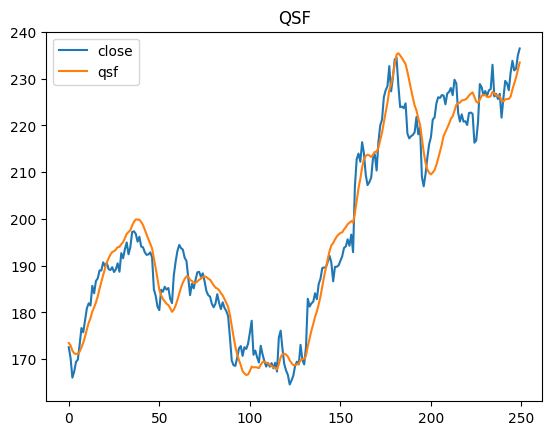

In [48]:
prices.tail(250).plot(
    y=["close", "qsf"],
    title="QSF",
    use_index=False,
);